In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from tqdm.auto import tqdm
import scipy.sparse as sp
import pickle as pkl
import os

In [2]:
import time
import argparse
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from math import ceil

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from utils import load_file, preprocessing, get_vocab, load_embeddings, create_gows, accuracy, generate_batches, AverageMeter
from models import MPAD

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import tqdm.auto as tqdm

[nltk_data] Downloading package stopwords to /home/sc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import networkx as nx
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [5]:
def create_gows(docs, vocab, window_size, directed, to_normalize, use_master_node):
    adj = list()
    features = list()
    idx2term = list()

    for doc in tqdm.tqdm(docs):
        edges = dict()

        idx = dict()
        l_terms = list()
        for i in range(len(doc)):
            if doc[i] not in idx:
                l_terms.append(doc[i])
                idx[doc[i]] = len(idx)
        idx2term.append(l_terms)
        if use_master_node:
            idx["master_node"] = len(idx)
        X = np.zeros(len(idx), dtype=np.int32)
        for w in idx:
            if w != "master_node":
                X[idx[w]] = vocab[w]
            else:
                X[idx[w]] = len(vocab)
        for i in range(len(doc)):
            for j in range(i + 1, i + window_size):
                if j < len(doc):
                    if (doc[i], doc[j]) in edges:
                        edges[(doc[i], doc[j])] += 1.0 / (j - i)
                        if not directed:
                            edges[(doc[j], doc[i])] += 1.0 / (j - i)
                    else:
                        edges[(doc[i], doc[j])] = 1.0 / (j - i)
                        if not directed:
                            edges[(doc[j], doc[i])] = 1.0 / (j - i)
            if use_master_node:
                edges[(doc[i], "master_node")] = 1.0
                edges[("master_node", doc[i])] = 1.0

        edge_s = list()
        edge_t = list()
        val = list()
        for edge in edges:
            edge_s.append(idx[edge[0]])
            edge_t.append(idx[edge[1]])
            val.append(edges[edge])
        A = sp.csr_matrix((val, (edge_s, edge_t)), shape=(len(idx), len(idx)))
        if len(edges) == 0:
            A = sp.csr_matrix(([0], ([0], [0])), shape=(1, 1))
            X = np.zeros(1, dtype=np.int32)

        if directed:
            A = A.transpose()
        if to_normalize and A.size > 1:
            A = normalize(A)
        adj.append(A)
        features.append(X)

    return adj, features, idx2term


In [31]:
def create_gows(docs, vocab, window_size, directed, to_normalize, use_master_node):
    adj = list()
    features = list()
    idx2term = list()
    
    for enum, doc in tqdm.tqdm(enumerate(docs)):
        edges = dict()

        idx = dict()
        l_terms = list()
        for i in range(len(doc)):
            if doc[i] not in idx:
                l_terms.append(doc[i])
                idx[doc[i]] = len(idx)
        idx2term.append(l_terms)
        if use_master_node:
            idx["master_node"] = len(idx)
        X = np.zeros(len(idx), dtype=np.int32)
        for w in idx:
            if w != "master_node":
                X[idx[w]] = vocab[w]
            else:
                X[idx[w]] = len(vocab)
        for i in range(len(doc)):
            for j in range(i + 1, i + window_size):
                if j < len(doc):
                    if (doc[i], doc[j]) in edges:
                        edges[(doc[i], doc[j])] += 1.0 / (j - i)
                        if not directed:
                            edges[(doc[j], doc[i])] += 1.0 / (j - i)
                    else:
                        edges[(doc[i], doc[j])] = 1.0 / (j - i)
                        if not directed:
                            edges[(doc[j], doc[i])] = 1.0 / (j - i)
            if use_master_node:
                edges[(doc[i], "master_node")] = 1.0
                edges[("master_node", doc[i])] = 1.0

        edge_s = list()
        edge_t = list()
        val = list()
        for edge in edges:
            edge_s.append(idx[edge[0]])
            edge_t.append(idx[edge[1]])
            val.append(edges[edge])
        A = sp.csr_matrix((val, (edge_s, edge_t)), shape=(len(idx), len(idx)))
        if len(edges) == 0:
            A = sp.csr_matrix(([0], ([0], [0])), shape=(1, 1))
            X = np.zeros(1, dtype=np.int32)

        if directed:
            A = A.transpose()
        if to_normalize and A.size > 1:
            A = normalize(A)
        adj.append(A)
        features.append(X)
      
    return adj, features, idx2term, docs


### Make Graph

In [12]:
args = {}
args['path_to_dataset'] = '../datasets/subjectivity.txt'
args['path_to_embeddings'] = "../GoogleNews-vectors-negative300.bin"
args['no_cuda'] = False
args['epochs'] = 200
args['lr'] = 0.001
args['hidden'] = 64
args['penultimate'] = 64
args['message_passing_layers']=2
args['window_size'] = 2
args['directed'] = True
args['use_master_node'] = True
args['normalize'] = True
args['dropout'] = 0.5
args['batch_size'] = 128
args['patience'] = 20
args = dotdict(args)

## Consolidated Vocab

In [8]:
docs, class_labels = load_file("../datasets/subjectivity/unique/consolidated.txt")
docs = preprocessing(docs)
vocab = get_vocab(docs)
embeddings = load_embeddings("../GoogleNews-vectors-negative300.bin", vocab)

Vocabulary size:  36104
Existing vectors: 29329


In [120]:
aug = "tells the other face of the story , with a dark and satiric look at new york wholesale habilitate manufacture , where shady make do are made for a dollar and mercilessness is a requirement for career succeeder . "
clean ="tells the other side of the story , with a dark and satirical look at new yorks wholesale garment industry , where shady deals are made for a buck and ruthlessness is a prerequisite for career success . "


aug = "with a dark and satiric look at new york wholesale habilitate manufacture , where shady make do are made for a dollar and mercilessness is a requirement for career succeeder . "
clean ="with a dark and satirical look at new yorks wholesale garment industry , where shady deals are made for a buck and ruthlessness is a prerequisite for career success . "


aug = preprocessing([aug])
clean = preprocessing([clean])

clean

[['with',
  'a',
  'dark',
  'and',
  'satirical',
  'look',
  'at',
  'new',
  'yorks',
  'wholesale',
  'garment',
  'industry',
  ',',
  'where',
  'shady',
  'deals',
  'are',
  'made',
  'for',
  'a',
  'buck',
  'and',
  'ruthlessness',
  'is',
  'a',
  'prerequisite',
  'for',
  'career',
  'success']]

## Original sentence

In [121]:
USE_MASTER_NODE = False
NORMALIZE = False
clean_adj, clean_features, _, _  = create_gows(clean, vocab, 4, args.directed, NORMALIZE, USE_MASTER_NODE)
clean_adj = clean_adj[0].todense()
clean_graph = nx.from_numpy_array(clean_adj) 

In [ ]:
aug_str = "with a dark and satiric look at new york wholesale habilitate manufacture , where shady make do are made for a dollar and mercilessness is a requirement for career succeeder . "
clean ="with a dark and satirical look at new yorks wholesale garment industry , where shady deals are made for a buck and ruthlessness is a prerequisite for career success . "


In [135]:
aug_node = [4, 10, 15,16,21,23,29]

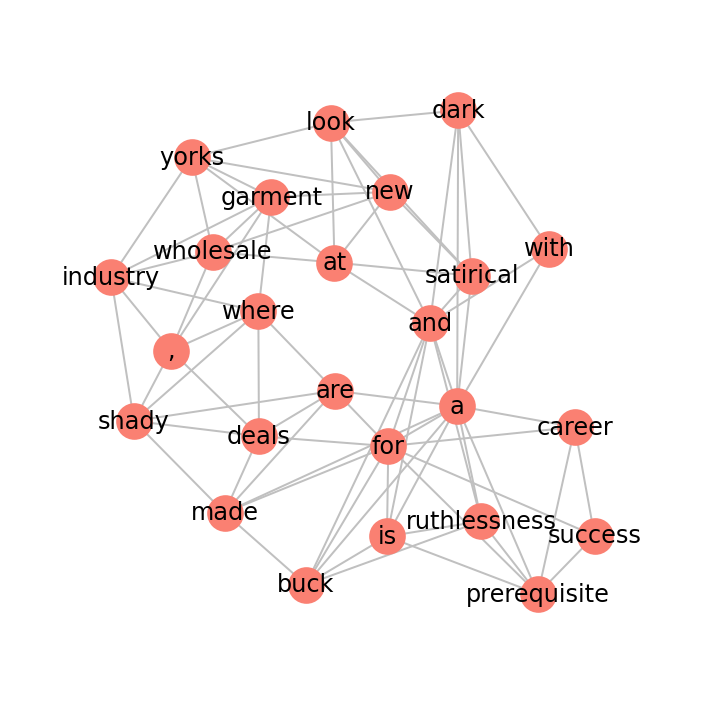

In [125]:
fig, ax = plt.subplots(1, figsize=(5,5))
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
nx.draw(clean_graph,
        labels=label_dict,
        ax=ax,pos=nx.kamada_kawai_layout(clean_graph),
        node_color='salmon',
        #node_color=intensities,
        #cmap=plt.cm.Wistia,
        edge_color='silver',)



plt.margins(x=0.2,y=0.2)
plt.tight_layout()

## Augmented Graphs

In [160]:
USE_MASTER_NODE = False
NORMALIZE = False
aug_adj, aug_features, _, _  = create_gows(aug, vocab, 4, args.directed, NORMALIZE, USE_MASTER_NODE)
aug_adj = aug_adj[0].todense()
print("Aug Graph: ",aug_adj.shape)
aug_graph = nx.from_numpy_array(aug_adj) 
print("Aug Graph: ",aug_graph.number_of_nodes())


Aug Graph:  (26, 26)
Aug Graph:  26


KeyError: 0

In [158]:
for enum, a in enumerate(clean[0]):
    print(enum,a)

0 with
1 a
2 dark
3 and
4 satirical
5 look
6 at
7 new
8 yorks
9 wholesale
10 garment
11 industry
12 ,
13 where
14 shady
15 deals
16 are
17 made
18 for
19 a
20 buck
21 and
22 ruthlessness
23 is
24 a
25 prerequisite
26 for
27 career
28 success


In [168]:
node_names = list(dict.fromkeys(aug[0])) 
for enum, i in enumerate(node_names):
    print(enum,i)

0 with
1 a
2 dark
3 and
4 satiric
5 look
6 at
7 new
8 york
9 wholesale
10 habilitate
11 manufacture
12 ,
13 where
14 shady
15 make
16 do
17 are
18 made
19 for
20 dollar
21 mercilessness
22 is
23 requirement
24 career
25 succeeder


Num Nodes:  26
{4: 'satiric', 10: 'habilitate', 15: 'make', 16: 'do', 21: 'mercilessness', 23: 'requirement'}


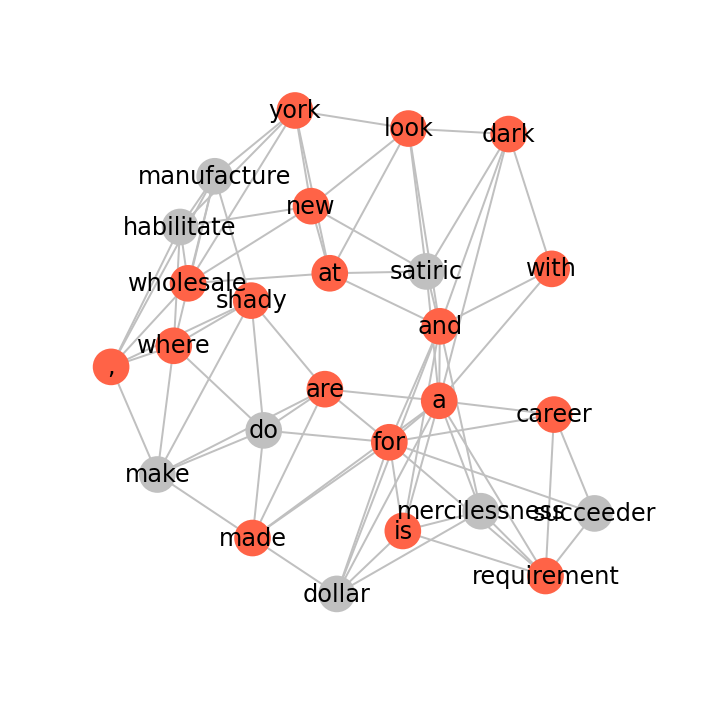

In [176]:
fig, ax = plt.subplots(1, figsize=(5,5))
node_names = list(dict.fromkeys(aug[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
    
node_color = ['tomato'] * aug_graph.number_of_nodes()

print("Num Nodes: ",aug_graph.number_of_nodes())
#aug_node = [4, 10, 15,16,21,23,29]
aug_nodes = [4, 10,11,15,16,20,21,25]
for i in aug_nodes:
    node_color[i] = 'silver'
nx.draw(aug_graph,
        labels=label_dict,
        ax=ax,
        pos=nx.kamada_kawai_layout(aug_graph),
        node_color=node_color,
        #cmap=plt.cm.Wistia,
        edge_color='silver',)


plt.margins(x=0.2,y=0.2)
plt.tight_layout()

G = nx.Graph()
G.add_nodes_from(aug_node)
label_dict = {}
for i,v in enumerate(node_names):
    if i in aug_node:
        label_dict[i] = node_names[i]  
print(label_dict)
#nx.draw_networkx_nodes(G,pos =nx.kamada_kawai_layout(aug_graph), node_color='white',labels=label_dict,edgecolors='silver')

In [175]:
from textwrap import wrap

Removal Nodes:  [19 14 10 13 26  0  0]
{0: 'tells', 10: 'and', 13: 'at', 14: 'new', 19: 'where', 26: 'ruthlessness'}


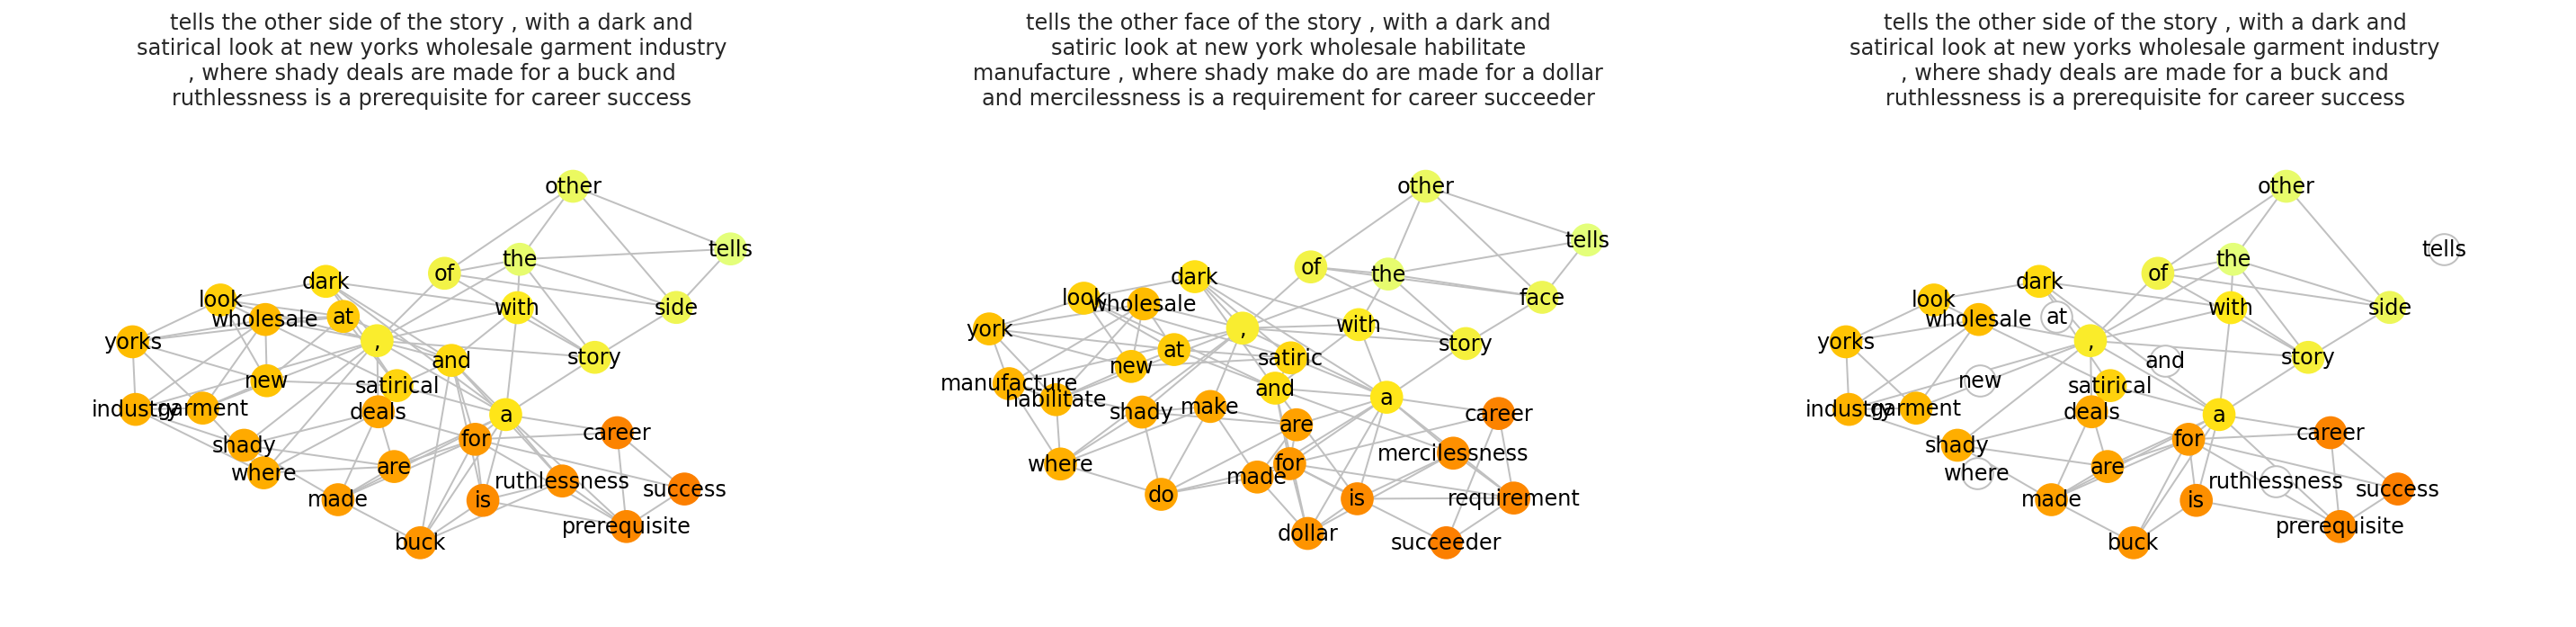

In [119]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
#base graph
clean_graph = nx.from_numpy_array(clean_adj) 
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
nx.draw(clean_graph,
        labels=label_dict,
        ax=axes[0],pos=nx.kamada_kawai_layout(clean_graph),
        node_color=intensities,
        cmap=plt.cm.Wistia,
        edge_color='silver',)

#aug graph 
node_names = list(dict.fromkeys(aug[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
nx.draw(aug_graph,
        labels=label_dict,
        ax=axes[1],pos=nx.kamada_kawai_layout(aug_graph),
        node_color=intensities,
        cmap=plt.cm.Wistia,
        edge_color='silver',)

clean_idx = " ".join(clean[0])

aug_idx = " ".join(aug[0])

clean_graph = nx.from_numpy_array(clean_adj) 
pos = nx.kamada_kawai_layout(clean_graph)
removal_nodes = np.random.randint(0,clean_graph.number_of_nodes(),int(np.ceil(clean_graph.number_of_nodes() * 0.2)))
print("Removal Nodes: ",removal_nodes)
clean_graph.remove_nodes_from(removal_nodes)
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
label_dict = {}
for i,v in enumerate(node_names):
    if i not in removal_nodes:
        label_dict[i] = node_names[i]  

intensities = [np.arange(clean_graph.number_of_nodes())]

nx.draw(clean_graph,
        labels=label_dict,
        pos= pos,
        node_color=intensities,
        cmap=plt.cm.Wistia,
        edge_color='silver',)

G = nx.Graph()
G.add_nodes_from(removal_nodes)
label_dict = {}
for i,v in enumerate(node_names):
    if i in removal_nodes:
        label_dict[i] = node_names[i]  
print(label_dict)
nx.draw(G,pos=pos,node_color='white',labels=label_dict,edgecolors='silver')

title = axes[0].set_title("\n".join(wrap(clean_idx, 55)))
title = axes[1].set_title("\n".join(wrap(aug_idx, 55)))
title = axes[2].set_title("\n".join(wrap(clean_idx, 55)))

plt.tight_layout()
axes[0].margins(x=0.2,y=0.2)
axes[1].margins(x=0.2,y=0.2)
axes[2].margins(x=0.2,y=0.2)

#axes[0].set_title(title)

Removal Nodes:  [4 8 4 2 7]
{2: 'dark', 4: 'satirical', 7: 'new', 8: 'yorks'}


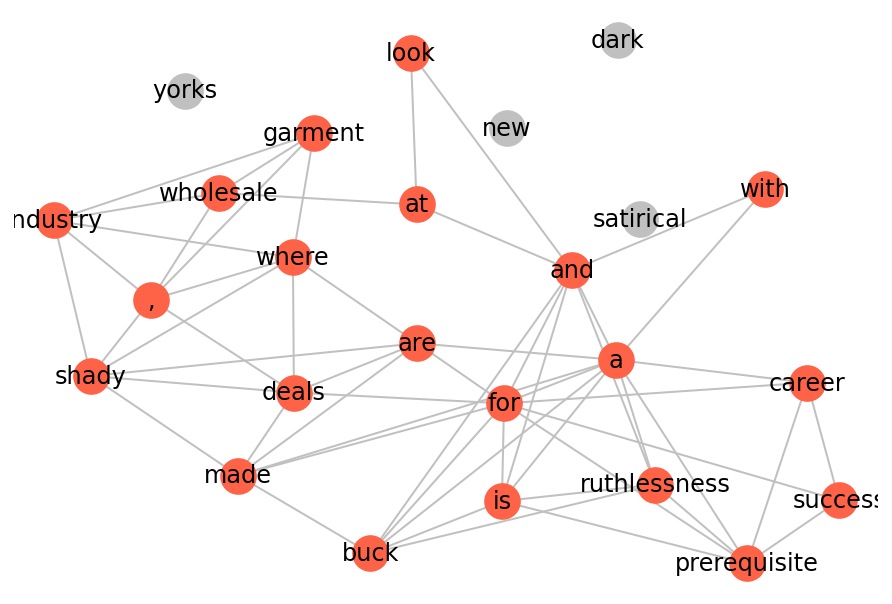

In [179]:
clean_graph = nx.from_numpy_array(clean_adj) 
pos = nx.kamada_kawai_layout(clean_graph)
removal_nodes = np.random.randint(0,clean_graph.number_of_nodes(),int(np.ceil(clean_graph.number_of_nodes() * 0.2)))
print("Removal Nodes: ",removal_nodes)
clean_graph.remove_nodes_from(removal_nodes)
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
label_dict = {}
for i,v in enumerate(node_names):
    if i not in removal_nodes:
        label_dict[i] = node_names[i]  

intensities = [np.arange(clean_graph.number_of_nodes())]

nx.draw(clean_graph,
        labels=label_dict,
        pos= pos,
        node_color='tomato',
        edge_color='silver',)

G = nx.Graph()
G.add_nodes_from(removal_nodes)
label_dict = {}
for i,v in enumerate(node_names):
    if i in removal_nodes:
        label_dict[i] = node_names[i]  
print(label_dict)
nx.draw(G,pos=pos,node_color='silver',labels=label_dict,edgecolors='silver')


Removal Nodes:  [ 5  4 19 15 12]


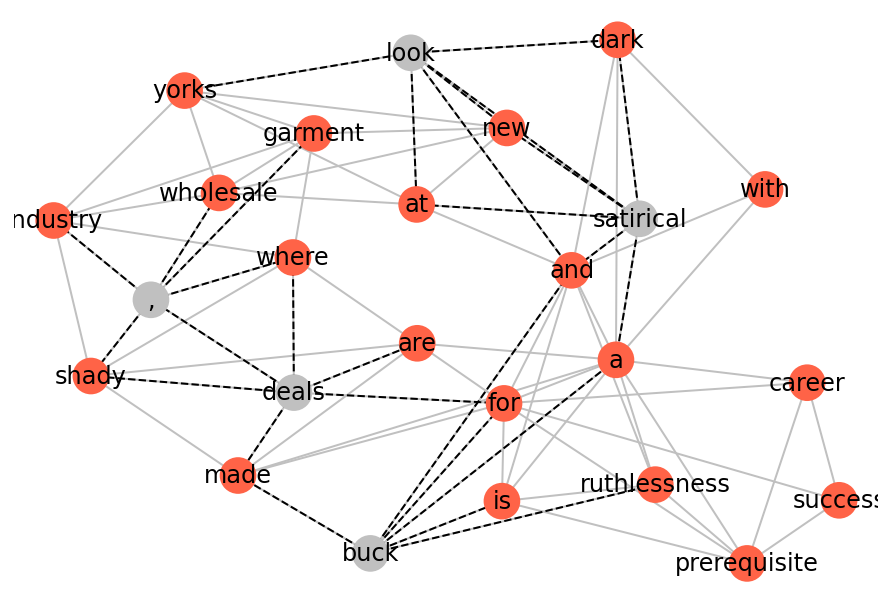

In [199]:
clean_graph = nx.from_numpy_array(clean_adj) 
pos = nx.kamada_kawai_layout(clean_graph)
removal_nodes = np.random.randint(0,clean_graph.number_of_nodes(),int(np.ceil(clean_graph.number_of_nodes() * 0.2)))
print("Removal Nodes: ",removal_nodes)
#clean_graph.remove_nodes_from(removal_nodes)
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
node_color = ['tomato'] * clean_graph.number_of_nodes()
for i in removal_nodes:
    node_color[i] = 'silver'

label_dict = {}
for i,v in enumerate(node_names):
    label_dict[i] = node_names[i]  

intensities = [np.arange(clean_graph.number_of_nodes())]

nx.draw(clean_graph,
        labels=label_dict,
        pos= pos,
        node_color=node_color,
        edge_color='silver',)

removal_edges = list(clean_graph.edges(removal_nodes))
nx.draw_networkx_edges(clean_graph,pos=pos,edgelist=removal_edges,edge_color='black',style='dashed')

TypeError: 'EdgeDataView' object does not support indexing

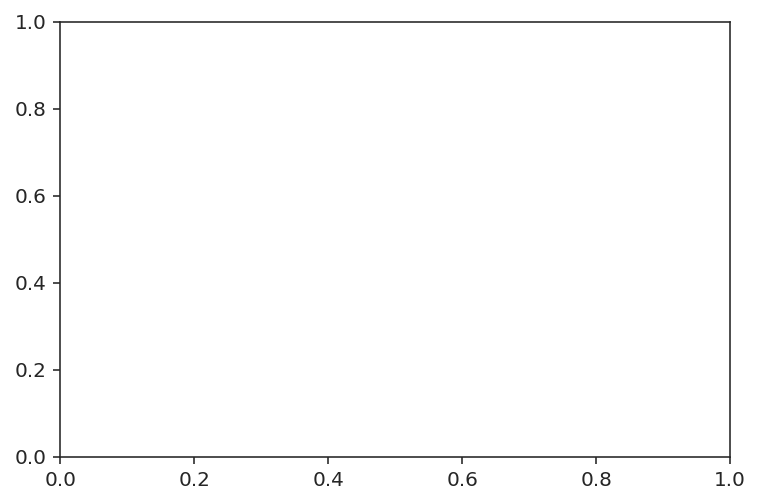

In [194]:
nx.draw_networkx_edges(clean_graph, ).edges()

In [196]:
clean_graph = nx.from_numpy_array(clean_adj) 
pos = nx.kamada_kawai_layout(clean_graph)
removal_nodes = np.random.randint(0,clean_graph.number_of_nodes(),int(np.ceil(clean_graph.number_of_nodes() * 0.2)))
print("Removal Nodes: ",removal_nodes)
#clean_graph.remove_nodes_from(removal_nodes)
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
node_color = ['tomato'] * clean_graph.number_of_nodes()
for i in removal_nodes:
    node_color[i] = 'silver'

label_dict = {}
for i,v in enumerate(node_names):
    label_dict[i] = node_names[i]  

intensities = [np.arange(clean_graph.number_of_nodes())]

nx.draw(clean_graph,
        labels=label_dict,
        pos= pos,
        node_color=node_color,
        edge_color='silver',)

removal_edges = list(clean_graph.edges(removal_nodes))
nx.draw_networkx_edges(clean_graph,pos=pos,edgelist=removal_edges,edge_color='black',style='dashed')

[(22, 18),
 (22, 1),
 (22, 20),
 (22, 21),
 (22, 23),
 (22, 24),
 (11, 8),
 (11, 9),
 (11, 10),
 (11, 12),
 (11, 13),
 (11, 14),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (1, 0),
 (1, 3),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 20),
 (1, 21),
 (1, 2),
 (1, 19),
 (1, 23),
 (5, 2),
 (5, 3),
 (5, 6),
 (5, 7),
 (5, 8)]

Num Nodes:  26
Removal Nodes:  [20 12 18 16 23]


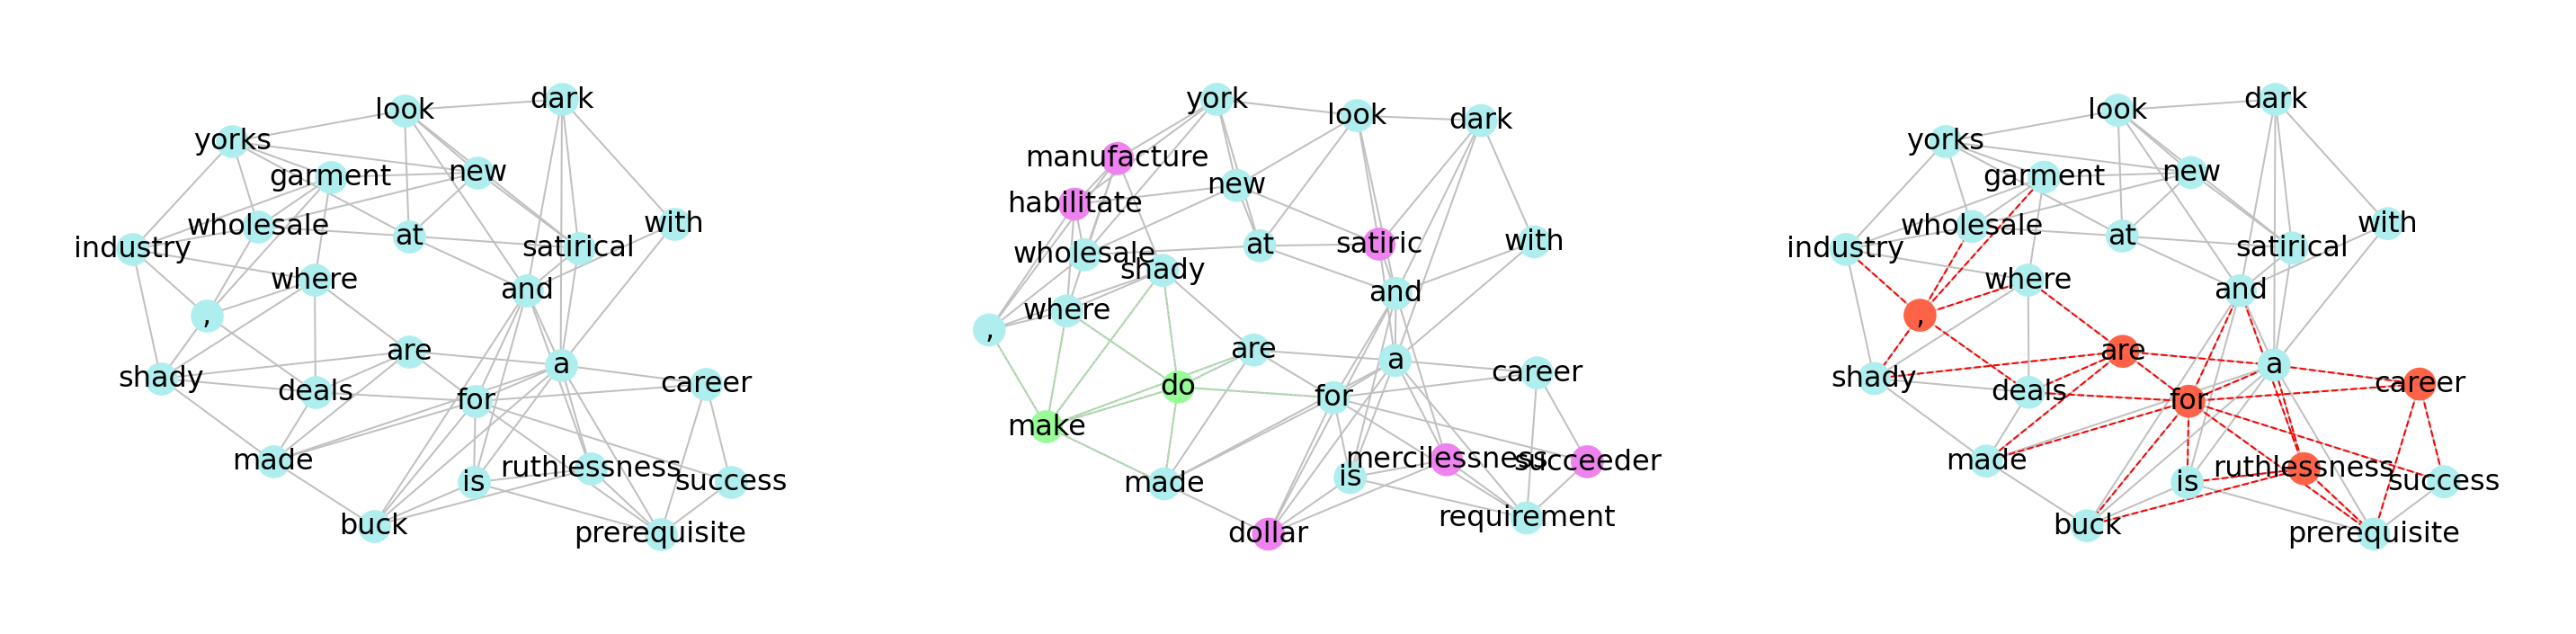

In [229]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
#base graph
clean_graph = nx.from_numpy_array(clean_adj) 
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
nx.draw(clean_graph,
        labels=label_dict,
        ax=axes[0],pos=nx.kamada_kawai_layout(clean_graph),
        node_color='paleturquoise',
        font_size=16,
        edge_color='silver',)

#aug graph 
node_names = list(dict.fromkeys(aug[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
    
node_color = ['paleturquoise'] * aug_graph.number_of_nodes()

print("Num Nodes: ",aug_graph.number_of_nodes())
#aug_node = [4, 10, 15,16,21,23,29]
aug_nodes = [4, 10,11,15,16,20,21,25]
for i in aug_nodes:
    if i != 15 and i != 16:
        node_color[i] = 'violet'
    elif i == 15 or i == 16:
        node_color[i] = 'palegreen'
nx.draw(aug_graph,
        labels=label_dict,
        ax=axes[1],
        pos=nx.kamada_kawai_layout(aug_graph),
        node_color=node_color,
        #cmap=plt.cm.Wistia,
        font_size=16,
        edge_color='silver',)

mod_edges = list(aug_graph.edges([15,16]))
nx.draw_networkx_edges(aug_graph,pos=nx.kamada_kawai_layout(aug_graph),edgelist=mod_edges,edge_color='palegreen',style='dotted',ax=axes[1])

#graph space
clean_graph = nx.from_numpy_array(clean_adj) 
pos = nx.kamada_kawai_layout(clean_graph)
removal_nodes = np.random.randint(0,clean_graph.number_of_nodes(),int(np.ceil(clean_graph.number_of_nodes() * 0.2)))
print("Removal Nodes: ",removal_nodes)
#clean_graph.remove_nodes_from(removal_nodes)
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
node_color = ['paleturquoise'] * clean_graph.number_of_nodes()
for i in removal_nodes:
    node_color[i] = 'tomato'

label_dict = {}
for i,v in enumerate(node_names):
    label_dict[i] = node_names[i]  

intensities = [np.arange(clean_graph.number_of_nodes())]

nx.draw(clean_graph,
        labels=label_dict,
        pos= pos,
        node_color=node_color,
        ax=axes[2],
        edge_color='silver',
        font_size=16)

removal_edges = list(clean_graph.edges(removal_nodes))
nx.draw_networkx_edges(clean_graph,pos=pos,edgelist=removal_edges,edge_color='red',style='dashed')

#title = axes[0].set_title("\n".join(wrap(clean_idx, 55)))
#title = axes[1].set_title("\n".join(wrap(aug_idx, 55)))
#title = axes[2].set_title("\n".join(wrap(clean_idx, 55)))

plt.tight_layout()
axes[0].margins(x=0.2,y=0.2)
axes[1].margins(x=0.2,y=0.2)
axes[2].margins(x=0.2,y=0.2)

#axes[0].set_title(title)

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
#base graph
clean_graph = nx.from_numpy_array(clean_adj) 
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
nx.draw(clean_graph,
        labels=label_dict,
        ax=axes[0],pos=nx.kamada_kawai_layout(clean_graph),
        node_color='paleturquoise',
        font_size=16,
        edge_color='silver',)

In [ ]:
#aug graph 
node_names = list(dict.fromkeys(aug[0])) #need to do this to preserve ordering!
intensities = [np.arange(len(node_names))]
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
    
node_color = ['paleturquoise'] * aug_graph.number_of_nodes()

print("Num Nodes: ",aug_graph.number_of_nodes())
#aug_node = [4, 10, 15,16,21,23,29]
aug_nodes = [4, 10,11,15,16,20,21,25]
for i in aug_nodes:
    if i != 15 and i != 16:
        node_color[i] = 'violet'
    elif i == 15 or i == 16:
        node_color[i] = 'palegreen'
nx.draw(aug_graph,
        labels=label_dict,
        ax=axes[1],
        pos=nx.kamada_kawai_layout(aug_graph),
        node_color=node_color,
        #cmap=plt.cm.Wistia,
        font_size=16,
        edge_color='silver',)

mod_edges = list(aug_graph.edges([15,16]))
nx.draw_networkx_edges(aug_graph,pos=nx.kamada_kawai_layout(aug_graph),edgelist=mod_edges,edge_color='palegreen',style='dotted',ax=axes[1])

Removal Nodes:  [24 19 15 20  0]


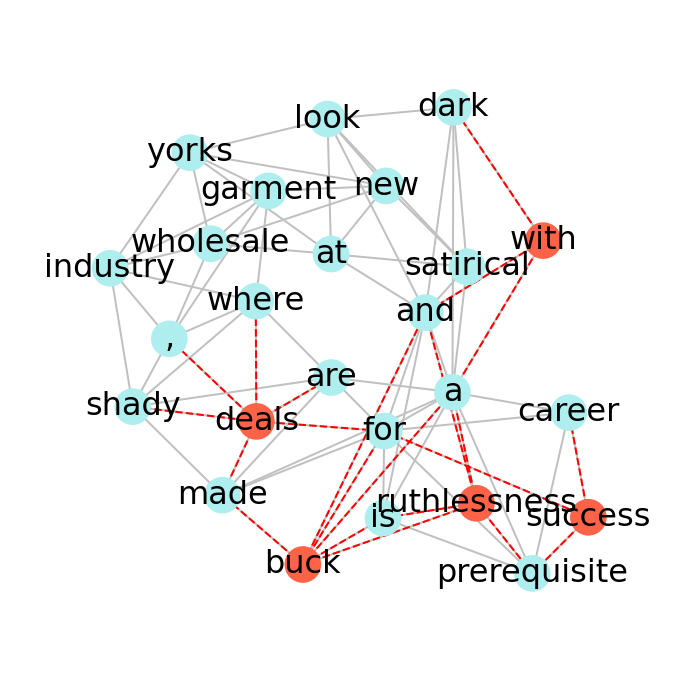

In [233]:
#graph space
fig, axes = plt.subplots(1,figsize=(6,6))
clean_graph = nx.from_numpy_array(clean_adj) 
pos = nx.kamada_kawai_layout(clean_graph)
removal_nodes = np.random.randint(0,clean_graph.number_of_nodes(),int(np.ceil(clean_graph.number_of_nodes() * 0.2)))
print("Removal Nodes: ",removal_nodes)
#clean_graph.remove_nodes_from(removal_nodes)
node_names = list(dict.fromkeys(clean[0])) #need to do this to preserve ordering!
node_color = ['paleturquoise'] * clean_graph.number_of_nodes()
for i in removal_nodes:
    node_color[i] = 'tomato'

label_dict = {}
for i,v in enumerate(node_names):
    label_dict[i] = node_names[i]  

intensities = [np.arange(clean_graph.number_of_nodes())]

nx.draw(clean_graph,
        labels=label_dict,
        pos= pos,
        node_color=node_color,
        ax=axes,
        edge_color='silver',
        font_size=16)

removal_edges = list(clean_graph.edges(removal_nodes))
nx.draw_networkx_edges(clean_graph,pos=pos,edgelist=removal_edges,edge_color='red',style='dashed')

#title = axes[0].set_title("\n".join(wrap(clean_idx, 55)))
#title = axes[1].set_title("\n".join(wrap(aug_idx, 55)))
#title = axes[2].set_title("\n".join(wrap(clean_idx, 55)))


axes.margins(x=0.2,y=0.2)


#axes[0].set_title(title)

In [218]:
clean_idx

'tells the other side of the story , with a dark and satirical look at new yorks wholesale garment industry , where shady deals are made for a buck and ruthlessness is a prerequisite for career success'

In [221]:
" ".join(aug[0])

'with a dark and satiric look at new york wholesale habilitate manufacture , where shady make do are made for a dollar and mercilessness is a requirement for career succeeder'

In [222]:
" ".join(clean[0])

'with a dark and satirical look at new yorks wholesale garment industry , where shady deals are made for a buck and ruthlessness is a prerequisite for career success'